Model Performance:
✅ Accuracy: 0.99
✨ ROC-AUC Score: 1.00



C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values, y=importance.index, palette='coolwarm')
C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:75: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:75: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:75: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:75: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rish

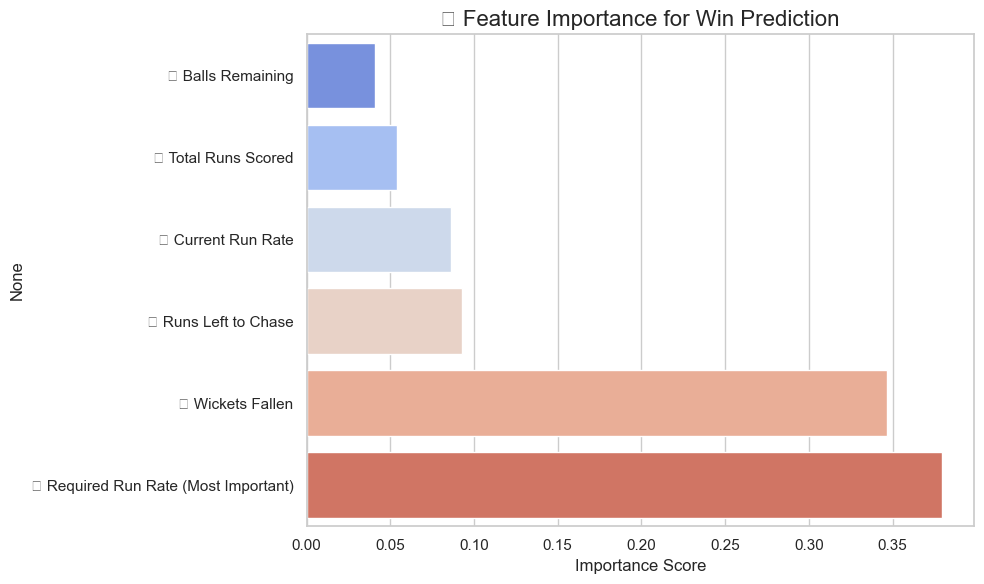

In [5]:
# Run this in a Jupyter Notebook cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.ticker import FuncFormatter

# Load Data
ball_df = pd.read_csv("IPL_Ball_by_Ball_2022.csv")
match_df = pd.read_csv("IPL_Matches_2022.csv")

# Merge Match Results
match_results = match_df[['ID', 'WinningTeam']]
merged = pd.merge(ball_df, match_results, on='ID', how='left')

# Filter for 2nd Innings
second_innings = merged[merged['innings'] == 2].copy()
second_innings['total_runs'] = second_innings.groupby(['ID'])['total_run'].cumsum()
second_innings['wickets'] = second_innings['isWicketDelivery'].cumsum()
second_innings['balls'] = second_innings['ballnumber'] + (second_innings['overs'] * 6)
second_innings['balls_left'] = 120 - second_innings['balls']

# Target score from 1st innings
first_innings = merged[merged['innings'] == 1].groupby('ID')['total_run'].sum().reset_index()
first_innings.columns = ['ID', 'target']
second_innings = pd.merge(second_innings, first_innings, on='ID', how='left')
second_innings['runs_left'] = second_innings['target'] - second_innings['total_runs']
second_innings['run_rate'] = second_innings['total_runs'] / (second_innings['balls'] / 6)
second_innings['required_run_rate'] = second_innings['runs_left'] / (second_innings['balls_left'] / 6)
second_innings['batting_team_won'] = (second_innings['BattingTeam'] == second_innings['WinningTeam']).astype(int)

# Feature Selection and Cleaning
features = ['total_runs', 'wickets', 'balls_left', 'runs_left', 'run_rate', 'required_run_rate', 'batting_team_won']
data = second_innings[features].replace([np.inf, -np.inf], np.nan).dropna().astype(float)

# Split Data
X = data.drop('batting_team_won', axis=1)
y = data['batting_team_won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("\033[1mModel Performance:\033[0m")
print(f"\u2705 Accuracy: {acc:.2f}")
print(f"\u2728 ROC-AUC Score: {auc:.2f}\n")

# Feature Importance Chart (with user-friendly labels and colors)
plt.figure(figsize=(10, 6))
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values()

labels = {
    'required_run_rate': '📈 Required Run Rate (Most Important)',
    'wickets': '💥 Wickets Fallen',
    'runs_left': '🎯 Runs Left to Chase',
    'run_rate': '🚀 Current Run Rate',
    'total_runs': '🏏 Total Runs Scored',
    'balls_left': '⏳ Balls Remaining'
}
importance.index = [labels[col] for col in importance.index]

sns.barplot(x=importance.values, y=importance.index, palette='coolwarm')
plt.title('🔥 Feature Importance for Win Prediction', fontsize=16)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Example Win Probability Visual (User-friendly)
def show_win_prediction(runs, wickets, balls_left, target):
    runs_left = target - runs
    current_rr = runs / ((120 - balls_left) / 6)
    req_rr = runs_left / (balls_left / 6)

    input_df = pd.DataFrame({
        'total_runs': [runs],
        'wickets': [wickets],
        'balls_left': [balls_left],
        'runs_left': [runs_left],
        'run_rate': [current_rr],
        'required_run_rate': [req_rr]
    })

    prob = model.predict_proba(input_df)[0][1]
    print("\n\033[1m📊 Live Match Situation:\033[0m")
    print(f"- Score: {runs}/{wickets}")
    print(f"- Balls Left: {balls_left}")
    print(f"- Runs Required: {runs_left}")
    print(f"- Required RR: {req_rr:.2f}")
    print(f"- Current RR: {current_rr:.2f}")

    plt.figure(figsize=(6, 3))
    plt.barh(['Win Probability'], [prob], color='limegreen')
    plt.barh(['Win Probability'], [1 - prob], left=[prob], color='orangered')
    plt.xlim(0, 1)
    plt.title("🎯 Win Predictor", fontsize=14)
    plt.xlabel("Probability")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))
    plt.tight_layout()
    plt.show()

# Example usage:
# show_win_prediction(runs=100, wickets=4, balls_left=36, target=160)


🏏 Enter current runs:  176
💥 Enter wickets fallen:  6
⏳ Enter balls left:  5
🎯 Enter target score:  190



📊 Live Match Situation:
- Score: 176/6
- Balls Left: 5
- Runs Required: 14
- Required RR: 16.80
- Current RR: 9.18


C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:108: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


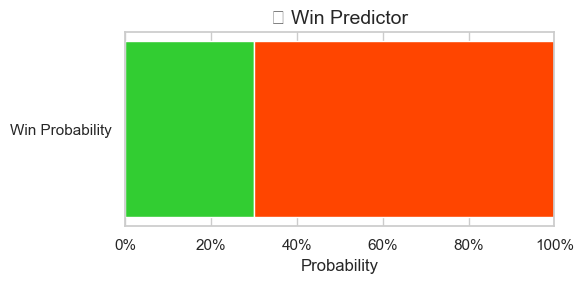

In [9]:
# 🔧 Input match situation manually
runs = int(input("🏏 Enter current runs: "))
wickets = int(input("💥 Enter wickets fallen: "))
balls_left = int(input("⏳ Enter balls left: "))
target = int(input("🎯 Enter target score: "))

# 🎯 Predict win probability
show_win_prediction(runs=runs, wickets=wickets, balls_left=balls_left, target=target)


## 📥 Enter Live Match Situation

🏏 Enter current runs scored:  178
💥 Enter wickets fallen (0–10):  6
⏳ Enter number of balls left (0–120):  5
🎯 Enter target score:  190



### 📊 Match Input Summary  
- **Score:** `178/6`  
- **Balls Left:** `5`  
- **Target:** `190`  



📊 Live Match Situation:
- Score: 178/6
- Balls Left: 5
- Runs Required: 12
- Required RR: 14.40
- Current RR: 9.29


C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:108: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


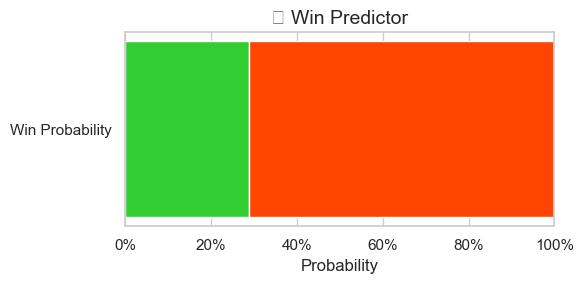

In [13]:
from IPython.display import display, Markdown

def get_valid_input(prompt, min_val, max_val):
    while True:
        try:
            val = int(input(prompt))
            if min_val <= val <= max_val:
                return val
            else:
                print(f"⚠️ Please enter a value between {min_val} and {max_val}.")
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

# 🔧 Input match situation manually (with guidance)
display(Markdown("## 📥 Enter Live Match Situation"))

runs = get_valid_input("🏏 Enter current runs scored: ", 0, 300)
wickets = get_valid_input("💥 Enter wickets fallen (0–10): ", 0, 10)
balls_left = get_valid_input("⏳ Enter number of balls left (0–120): ", 0, 120)
target = get_valid_input("🎯 Enter target score: ", runs, 350)  # must be ≥ runs

# 📝 Display match summary
display(Markdown(f"""
### 📊 Match Input Summary  
- **Score:** `{runs}/{wickets}`  
- **Balls Left:** `{balls_left}`  
- **Target:** `{target}`  
"""))

# 🎯 Predict win probability
show_win_prediction(runs=runs, wickets=wickets, balls_left=balls_left, target=target)


In [15]:
def verdict(prob):
    if prob >= 0.85:
        return "🟢 Very High Chance of Winning!"
    elif prob >= 0.65:
        return "🟩 Likely to Win"
    elif prob >= 0.45:
        return "🟨 Match is in the balance"
    elif prob >= 0.25:
        return "🟥 Unlikely to Win"
    else:
        return "🔴 Very Low Chance of Winning"

# Add to the bottom of your show_win_prediction output:
# Example call (after prediction)
prob = model.predict_proba(pd.DataFrame({
    'total_runs': [runs],
    'wickets': [wickets],
    'balls_left': [balls_left],
    'runs_left': [target - runs],
    'run_rate': [runs / ((120 - balls_left)/6)],
    'required_run_rate': [(target - runs) / (balls_left / 6)]
}))[0][1]

print(f"📢 Verdict: {verdict(prob)}")


📢 Verdict: 🟥 Unlikely to Win


🔄 Simulate What-If Scenario:


📈 Add how many more runs? (e.g. 10):  12
💔 Lose how many more wickets? (e.g. 1):  1


🔍 New Scenario: 190/7 with 5 balls left

📊 Live Match Situation:
- Score: 190/7
- Balls Left: 5
- Runs Required: 0
- Required RR: 0.00
- Current RR: 9.91


C:\Users\risha\AppData\Local\Temp\ipykernel_24408\1050303075.py:108: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


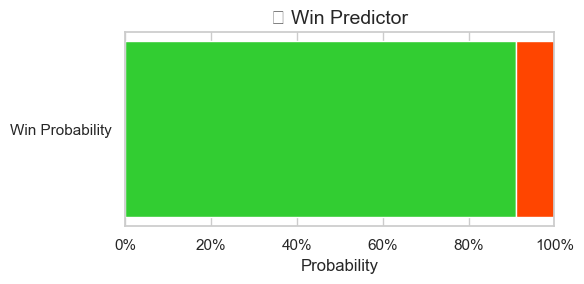

In [17]:
# 🔁 What-if scenario simulation
print("🔄 Simulate What-If Scenario:")
delta_runs = int(input("📈 Add how many more runs? (e.g. 10): "))
delta_wickets = int(input("💔 Lose how many more wickets? (e.g. 1): "))

sim_runs = runs + delta_runs
sim_wickets = min(wickets + delta_wickets, 10)

print(f"🔍 New Scenario: {sim_runs}/{sim_wickets} with {balls_left} balls left")
show_win_prediction(runs=sim_runs, wickets=sim_wickets, balls_left=balls_left, target=target)

## Probability Curve Over Overs ##

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_win_prob_curve(match_id, target, model):
    match_data = ball_df[ball_df['ID'] == match_id].copy()

    curve_data = []
    total_runs = 0
    wickets = 0

    for i, row in match_data.iterrows():
        over = row['overs']
        ball_number = int(over * 6)

        total_runs += row['total_run']
        if row['isWicketDelivery'] == 1:
            wickets += 1

        balls_left = 120 - ball_number
        runs_left = max(target - total_runs, 0)

        if balls_left == 0 or wickets == 10:
            win_prob = 0.0
        else:
            run_rate = total_runs / ((ball_number) / 6 + 0.0001)
            required_run_rate = runs_left / (balls_left / 6 + 0.0001)

            features = pd.DataFrame([{
                'total_runs': total_runs,
                'wickets': wickets,
                'balls_left': balls_left,
                'runs_left': runs_left,
                'run_rate': run_rate,
                'required_run_rate': required_run_rate
            }])

            prob = model.predict_proba(features)[0][1]
            win_prob = prob

        curve_data.append({
            'over': over,
            'win_prob': win_prob * 100  # for %
        })

    # 📈 Plotting
    df_curve = pd.DataFrame(curve_data)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_curve, x='over', y='win_prob', color='green', marker='o')
    plt.title('📈 Win Probability Over Time')
    plt.xlabel('Over')
    plt.ylabel('Win Probability (%)')
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(50, color='gray', linestyle=':', label='50%')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 🎬 Simulate Full Match Win Probability Curve

🆔 Enter Match ID (e.g. 1312200):  1312199
🎯 Enter Target Score:  178



📊 Generating Win Probability Curve for Match ID: 1312199 with Target: 178



C:\Users\risha\AppData\Local\Temp\ipykernel_24408\2446397672.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\risha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


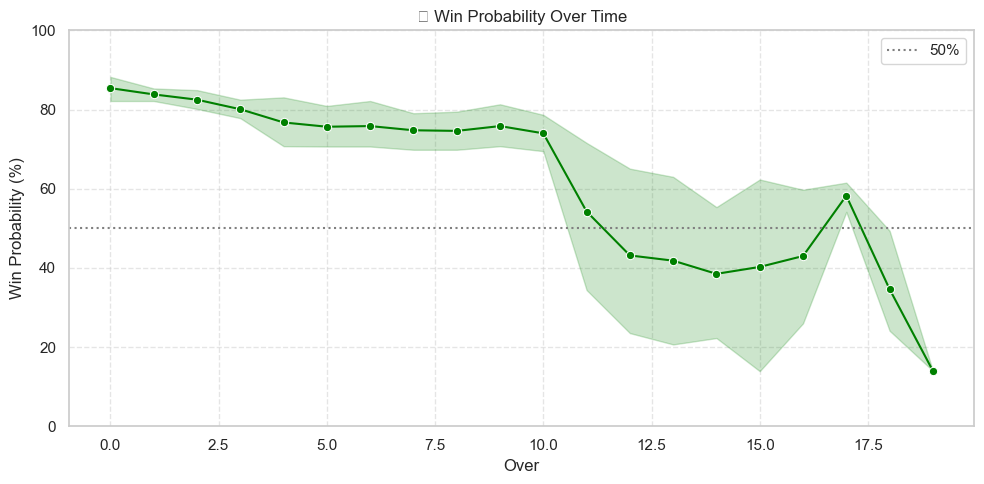

In [27]:
from IPython.display import Markdown, display

display(Markdown("## 🎬 Simulate Full Match Win Probability Curve"))

try:
    match_id = int(input("🆔 Enter Match ID (e.g. 1312200): "))
    target = int(input("🎯 Enter Target Score: "))

    if match_id not in ball_df['ID'].unique():
        print("❌ That Match ID doesn't exist in the ball-by-ball dataset.")
    else:
        print(f"\n📊 Generating Win Probability Curve for Match ID: {match_id} with Target: {target}\n")
        simulate_win_prob_curve(match_id=match_id, target=target, model=model)

except ValueError:
    print("❌ Please enter valid numeric values for Match ID and Target.")

